In [1]:
!pip install -q scikit-learn numpy pandas altair kaggle==1.6.6 graphviz imbalanced-learn
!pip install -q xgboost lightgbm catboost statsmodels plotly optuna tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.0 MB/s eta 0:00:00


In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (11.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 124926 files and direc

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#최대한 간결하게 적느라 빼놓았지만,
#.head(), .info(), .value_counts(), .isnull().sum() 등을 활용하여
#전처리 후 데이터가 어떻게 변화되는지 확인하는 것이 좋을 것 같습니다!

In [5]:
#한글 폰트(아래 feature importance 그래프에서 한글이 깨지는 것을 방지하기 위해)
plt.rc('font', family='NanumBarunGothic')

# Data Load

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
train = pd.read_csv('/content/drive/My Drive/Aimers6/train.csv').drop(columns=['ID'])
test = pd.read_csv('/content/drive/My Drive/Aimers6/test.csv').drop(columns=['ID'])

In [8]:
X = train#.drop('임신 성공 여부', axis=1) #몇몇 피처는 target 인코딩 할 것이기 때문에, 그 후에 드랍하였습니다.
y = train['임신 성공 여부']

# Data Pre-processing

In [9]:
# "알 수 없음"을 "만43-44세"로 변경하였는데, 다른 나이 구간으로 해보셔도 될 것 같습니다.
X['시술 당시 나이'] = X['시술 당시 나이'].replace('알 수 없음', '만43-44세')
test['시술 당시 나이'] = test['시술 당시 나이'].replace('알 수 없음', '만43-44세')

# Target Encoding 적용
age_success_rate = X.groupby("시술 당시 나이")["임신 성공 여부"].mean()
X['시술 당시 나이'] = X['시술 당시 나이'].map(age_success_rate)
test['시술 당시 나이'] = test['시술 당시 나이'].map(age_success_rate)


In [10]:
# 배아 생성 주요 이유 그룹화 (Treatment, Success, Fail)           #EDA 결과 임신 성공률에 차이가 나서 그룹화 해보았음.
reason_mapping = {
    '현재 시술용': 'Treatment',
    '기증용, 배아 저장용, 현재 시술용': 'Success',
    '기증용, 현재 시술용': 'Success',
    '난자 저장용, 현재 시술용': 'Success',
    '배아 저장용, 현재 시술용': 'Success',

    '기증용': 'Fail',
    '기증용, 난자 저장용': 'Fail',
    '기증용, 배아 저장용': 'Fail',
    '난자 저장용, 배아 저장용': 'Fail',
    '난자 저장용': 'Fail',
    '배아 저장용': 'Fail',
    '연구용, 배아 저장용, 연구용': 'Fail',
    '배아 저장용, 연구용, 현재 시술용': 'Fail'
}

# 데이터 변환 적용
X['배아 생성 주요 이유'] = X['배아 생성 주요 이유'].map(reason_mapping).fillna('Treatment')

# 변환 결과 확인
print(X['배아 생성 주요 이유'].value_counts())


배아 생성 주요 이유
Treatment    240025
Fail          12434
Success        3892
Name: count, dtype: int64


In [11]:
# 각 그룹별 평균 임신 성공률 계산
success_rate = X.groupby("배아 생성 주요 이유")["임신 성공 여부"].mean()

# Target Encoding 적용
X['배아 생성 주요 이유'] = X['배아 생성 주요 이유'].map(success_rate)

In [12]:
#test에도 똑같이 적용
test['배아 생성 주요 이유'] = test['배아 생성 주요 이유'].map(reason_mapping).fillna('Treatment')

test['배아 생성 주요 이유'] = test['배아 생성 주요 이유'].map(success_rate)


In [13]:
# '난자 출처' 피처의 '알 수 없음' 값을 '본인 제공' 값으로(최빈값으로) 변환
X['난자 출처'] = X['난자 출처'].replace('알 수 없음', '본인 제공')

# 결과 확인
print(X['난자 출처'].value_counts())

난자 출처
본인 제공    240582
기증 제공     15769
Name: count, dtype: int64


In [14]:

test['난자 출처'] = test['난자 출처'].replace('알 수 없음', '본인 제공')

print(test['난자 출처'].value_counts())

난자 출처
본인 제공    84573
기증 제공     5494
Name: count, dtype: int64


In [15]:
X = X.drop('불임 원인 - 여성 요인', axis=1)
X = X.drop('난자 채취 경과일', axis=1)
X = X.drop('난자 해동 경과일', axis=1)
X = X.drop('난자 혼합 경과일', axis=1)
X = X.drop('불임 원인 - 정자 면역학적 요인', axis=1)
X = X.drop('불임 원인 - 정자 운동성', axis=1)
X = X.drop('불임 원인 - 자궁경부 문제', axis=1)
X = X.drop('불임 원인 - 정자 형태', axis=1)
X = X.drop('배아 해동 경과일', axis=1)
X = X.drop('불임 원인 - 정자 농도', axis=1)
X = X.drop('시술 유형', axis=1)
X = X.drop('임신 시도 또는 마지막 임신 경과 연수', axis=1)
X = X.drop('착상 전 유전 검사 사용 여부', axis=1)
X = X.drop('PGD 시술 여부', axis=1)
X = X.drop('PGS 시술 여부', axis=1)
X = X.drop('배란 유도 유형', axis=1)


In [16]:
test = test.drop('불임 원인 - 여성 요인', axis=1)
test = test.drop('난자 채취 경과일', axis=1)
test = test.drop('난자 해동 경과일', axis=1)
test = test.drop('난자 혼합 경과일', axis=1)
test = test.drop('불임 원인 - 정자 면역학적 요인', axis=1)
test = test.drop('불임 원인 - 정자 운동성', axis=1)
test = test.drop('불임 원인 - 자궁경부 문제', axis=1)
test = test.drop('불임 원인 - 정자 형태', axis=1)
test = test.drop('배아 해동 경과일', axis=1)
test = test.drop('불임 원인 - 정자 농도', axis=1)
test = test.drop('시술 유형', axis=1)
test = test.drop('임신 시도 또는 마지막 임신 경과 연수', axis=1)
test = test.drop('착상 전 유전 검사 사용 여부', axis=1)
test = test.drop('PGD 시술 여부', axis=1)
test = test.drop('PGS 시술 여부', axis=1)
test = test.drop('배란 유도 유형', axis=1)

In [17]:
#'시술 시기 코드'에 One-Hot Encoding 적용
from sklearn.preprocessing import OneHotEncoder

# One-Hot Encoding 적용 열
one_hot_cols = ['시술 시기 코드']

# One-Hot Encoding 적용
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Train 데이터 변환
onehot_encoded = one_hot_encoder.fit_transform(X[one_hot_cols])
onehot_encoded_df = pd.DataFrame(onehot_encoded, columns=one_hot_encoder.get_feature_names_out(one_hot_cols), index=X.index)

# 기존 데이터와 병합
X = pd.concat([X.drop(columns=one_hot_cols), onehot_encoded_df], axis=1)

In [18]:
#one-hot encoding
test_encoded = one_hot_encoder.transform(test[one_hot_cols])
test_encoded_df = pd.DataFrame(test_encoded, columns=one_hot_encoder.get_feature_names_out(one_hot_cols), index=test.index)

# 기존 데이터와 병합
test = pd.concat([test.drop(columns=one_hot_cols), test_encoded_df], axis=1)

In [19]:
categorical_columns = [
    # "시술 시기 코드", #one-hot
    "시술 당시 나이", #target-encoder
    # "시술 유형", #삭제
    "특정 시술 유형", #기회되면 target-encoder
    "배란 자극 여부", #ordinal
    # "배란 유도 유형", #삭제
    "단일 배아 이식 여부", #ordinal
    # "착상 전 유전 검사 사용 여부", #삭제
    "착상 전 유전 진단 사용 여부", #ordinal
    "남성 주 불임 원인", #ordinal
    "남성 부 불임 원인", #ordinal
    "여성 주 불임 원인", #ordinal
    "여성 부 불임 원인", #ordinal
    "부부 주 불임 원인", #ordinal
    "부부 부 불임 원인", #ordinal
    "불명확 불임 원인", #ordinal
    "불임 원인 - 난관 질환", #ordinal
    "불임 원인 - 남성 요인", #ordinal
    "불임 원인 - 배란 장애", #ordinal
    # "불임 원인 - 여성 요인", #삭제
    # "불임 원인 - 자궁경부 문제", #삭제
    "불임 원인 - 자궁내막증", #ordinal
    # "불임 원인 - 정자 농도", #삭제
    # "불임 원인 - 정자 면역학적 요인", #삭제
    # "불임 원인 - 정자 운동성", #삭제
    # "불임 원인 - 정자 형태", #삭제
    # "배아 생성 주요 이유", #그룹화, target-encoder
    "총 시술 횟수", #ordinal, 추후에 target 고민
    "클리닉 내 총 시술 횟수", #ordinal, 추후에 target 고민
    "IVF 시술 횟수", #ordinal, 추후에 target 고민
    "DI 시술 횟수", #ordinal
    "총 임신 횟수", #ordinal
    "IVF 임신 횟수", #ordinal
    "DI 임신 횟수", #ordinal
    "총 출산 횟수", #ordinal
    "IVF 출산 횟수", #ordinal
    "DI 출산 횟수", #ordinal
    "난자 출처", #ordinal, '알 수 없음' -> '본인 제공'
    "정자 출처", #ordinal
    "난자 기증자 나이", #ordinal
    "정자 기증자 나이", #ordinal
    "동결 배아 사용 여부", #ordinal, 삭제 고민
    "신선 배아 사용 여부",#ordinal, 삭제 고민
    "기증 배아 사용 여부",#ordinal, 삭제 고민
    "대리모 여부",#ordinal, 삭제 고민
    # "PGD 시술 여부", #삭제
    # "PGS 시술 여부" #삭제
]

In [20]:
# 카테고리형 컬럼들을 문자열로 변환
for col in categorical_columns:
    X[col] = X[col].astype(str)
    test[col] = test[col].astype(str)

In [21]:
#Ordinal Encoding 적용
from sklearn.preprocessing import  OrdinalEncoder

ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

X_train_encoded = X.copy()
X_train_encoded[categorical_columns] = ordinal_encoder.fit_transform(X[categorical_columns])

X_test_encoded = test.copy()
X_test_encoded[categorical_columns] = ordinal_encoder.transform(test[categorical_columns])

In [22]:
#수치형 칼럼

numeric_columns = [
    # "임신 시도 또는 마지막 임신 경과 연수", #삭제
    "총 생성 배아 수", #결측치 0 대체
    "미세주입된 난자 수", #결측치 0 대체
    "미세주입에서 생성된 배아 수", #결측치 0 대체
    # "이식된 배아 수", #결측치 2로 대체
    "미세주입 배아 이식 수", #결측치 0 대체
    "저장된 배아 수", #결측치 0 대체
    "미세주입 후 저장된 배아 수", #결측치 0 대체
    "해동된 배아 수", #결측치 0 대체
    "해동 난자 수", #결측치 0 대체
    "수집된 신선 난자 수", #결측치 0 대체
    "저장된 신선 난자 수", #결측치 0 대체
    "혼합된 난자 수", #결측치 0 대체
    "파트너 정자와 혼합된 난자 수", #결측치 0 대체
    "기증자 정자와 혼합된 난자 수", #결측치 0 대체
    # "난자 채취 경과일", #삭제
    # "난자 해동 경과일", #삭제
    # "난자 혼합 경과일", #삭제
    "배아 이식 경과일",
    # "배아 해동 경과일" #삭제
]

In [23]:
#"이식된 배아 수"는 최빈값이 2이므로 따로 빼서 결측치를 2로 대체
numeric_fillna_2 = [
    "이식된 배아 수"
]

In [24]:
X_train_encoded[numeric_columns] = X_train_encoded[numeric_columns].fillna(0) #나머지
X_train_encoded[numeric_fillna_2] = X_train_encoded[numeric_fillna_2].fillna(2) #이식된 배아 수

X_test_encoded[numeric_columns] = X_test_encoded[numeric_columns].fillna(0)
X_test_encoded[numeric_fillna_2] = X_test_encoded[numeric_fillna_2].fillna(2)

In [25]:
X_train_encoded = X_train_encoded.drop(columns=['임신 성공 여부']) #처음에 안빼줬던 target 변수 빼주기

# Model Training

## 1. CatBoost

In [26]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Stratified K-Fold 설정 (데이터 불균형 고려)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# CatBoost 모델 생성 (하이퍼파라미터)
cat_model = CatBoostClassifier(
    iterations=1500,  # 학습 반복 횟수 (트리 개수)
    learning_rate=0.03,  # 학습률 (default: 0.03)
    depth=6,  # 트리 깊이 (default: 6)
    l2_leaf_reg=3,  # L2 정규화 계수 (default: 3)
    colsample_bylevel=0.8,
    eval_metric='AUC',  # 평가 기준을 ROC-AUC로 설정
    random_seed=42,
    max_bin=300,
    verbose=100,  # 학습 로그 출력 간격
    early_stopping_rounds=100
    # task_type="GPU"  # GPU 사용 가능하면 활성화
)

# 모델 학습
cat_model.fit(X_train_encoded, y)

# 교차 검증 수행 (ROC-AUC 기준)
roc_auc_scores = cross_val_score(cat_model, X_train_encoded, y, cv=skf, scoring='roc_auc')

# 결과 출력
print(f"ROC-AUC scores: {roc_auc_scores}")
print(f"Mean ROC-AUC score: {roc_auc_scores.mean()}")


0:	total: 219ms	remaining: 5m 27s
100:	total: 8.17s	remaining: 1m 53s
200:	total: 17.9s	remaining: 1m 55s
300:	total: 26.4s	remaining: 1m 45s
400:	total: 36.3s	remaining: 1m 39s
500:	total: 45.7s	remaining: 1m 31s
600:	total: 53.8s	remaining: 1m 20s
700:	total: 1m 2s	remaining: 1m 11s
800:	total: 1m 11s	remaining: 1m 2s
900:	total: 1m 19s	remaining: 52.8s
1000:	total: 1m 28s	remaining: 44.2s
1100:	total: 1m 37s	remaining: 35.4s
1200:	total: 1m 45s	remaining: 26.2s
1300:	total: 1m 54s	remaining: 17.5s
1400:	total: 2m 1s	remaining: 8.62s
1499:	total: 2m 11s	remaining: 0us
0:	total: 56.5ms	remaining: 1m 24s
100:	total: 6.74s	remaining: 1m 33s
200:	total: 12.7s	remaining: 1m 22s
300:	total: 17.9s	remaining: 1m 11s
400:	total: 25.1s	remaining: 1m 8s
500:	total: 30.2s	remaining: 1m
600:	total: 37.4s	remaining: 55.9s
700:	total: 42.4s	remaining: 48.3s
800:	total: 49s	remaining: 42.8s
900:	total: 54.6s	remaining: 36.3s
1000:	total: 59.7s	remaining: 29.8s
1100:	total: 1m 6s	remaining: 24.2s
120

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49885 (\N{HANGUL SYLLABLE SIG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/loc

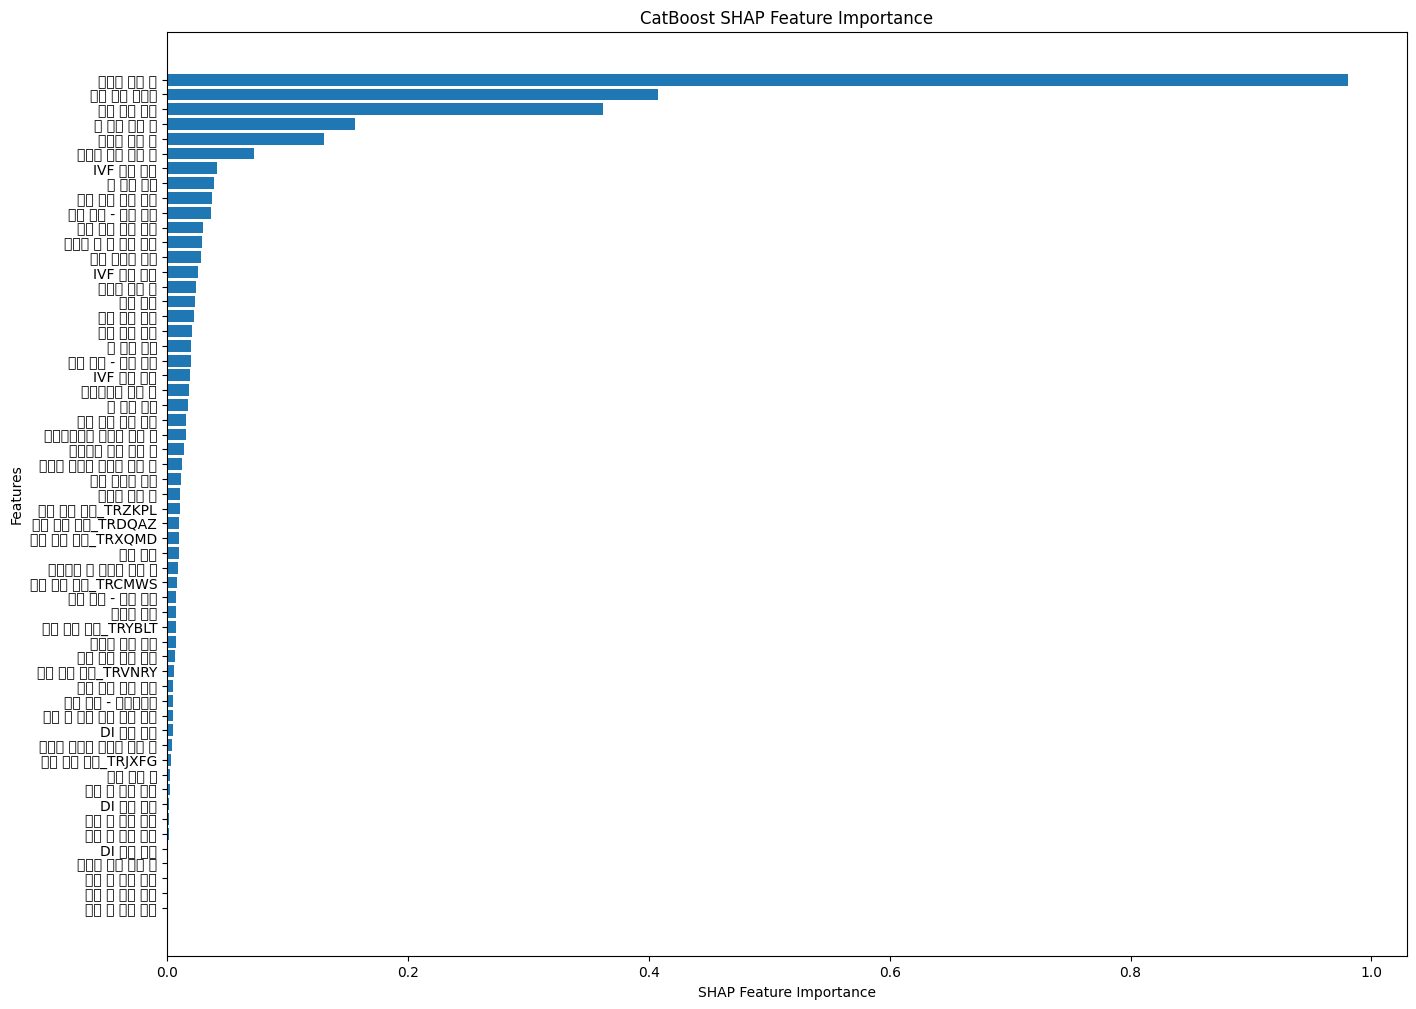

In [27]:
'''CatBoost Feature Importance'''
# Permutation Importance 확인 (Shapley Value 기반)
from catboost import Pool
train_pool = Pool(X_train_encoded)

feature_importance_shap = cat_model.get_feature_importance(type="ShapValues", data=train_pool)
feature_names = cat_model.feature_names_
# Shap Values의 평균을 Feature Importance로 변환
shap_importance = np.abs(feature_importance_shap).mean(axis=0)  # 절댓값 평균
shap_df = pd.DataFrame({'Feature': feature_names, 'SHAP Importance': shap_importance[:-1]})  # 마지막 열은 Bias

# 중요도 순 정렬
shap_df = shap_df.sort_values(by='SHAP Importance', ascending=False)

# Feature Importance 시각화
plt.figure(figsize=(16, 12))
plt.barh(shap_df['Feature'], shap_df['SHAP Importance'])
plt.xlabel("SHAP Feature Importance")
plt.ylabel("Features")
plt.title("CatBoost SHAP Feature Importance")
plt.gca().invert_yaxis()
plt.show()


# Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Stratified K-Fold 설정 (데이터 불균형 고려)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rf_model = RandomForestClassifier(
    n_estimators=100, # 100개의 Decision Tree를 만든다
    max_depth=5, # 각 Decision Tree의 깊이는 5로 제한한다
    max_features='sqrt', # 30개의 특성값 공간 중 약 5개만 사용한다
    max_samples=0.5, # 전체 훈련 샘플 중 50%만 Bootstrap한다
    random_state=42
)

# 모델 학습
rf_model.fit(X_train_encoded, y)

# 교차 검증 수행 (ROC-AUC 기준)
roc_auc_scores = cross_val_score(rf_model, X_train_encoded, y, cv=skf, scoring='roc_auc')

# 결과 출력
print(f"ROC-AUC scores: {roc_auc_scores}")
print(f"Mean ROC-AUC score: {roc_auc_scores.mean()}")

ROC-AUC scores: [0.71969458 0.72311396 0.71936186]
Mean ROC-AUC score: 0.7207234698032163


In [29]:
from sklearn.ensemble import GradientBoostingClassifier

# Stratified K-Fold 설정 (데이터 불균형 고려)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

gb_model = GradientBoostingClassifier(
    n_estimators=100, # 최대 100개의 Decision Tree를 만들 것이다. 하지만, 중간에 Loss가 0가 된다면, 더 이상 Decision Tree를 생성하지 않고 훈련이 종료된다.
    learning_rate=0.1, # 각 Decision Tree가 결과에 미치는 영향을 나타낸다(Shrinkage). 과대적합을 막기 위해서 낮은 값으로 설정해보자
    subsample=0.8, # 각 Decision Tree 훈련에 사용할 샘플의 개수를 나타낸다. 80%만 활용해보자.
    max_depth=3, # Decision Tree의 깊이를 나타낸다. 많이 깊어지지 않도록 해보자.
    min_samples_leaf=1, # Decision Tree의 잎 노드에 필요한 샘플의 개수를 나타낸다. 깊이를 조절했으므로, 이건 그냥 1로 놔두자.
    max_features=1.0, # Random Subspace의 적용을 나타낸다. 전체 Feature를 다 사용하자.
    random_state=42
)

# 모델 학습
gb_model.fit(X_train_encoded, y)

# 교차 검증 수행 (ROC-AUC 기준)
roc_auc_scores = cross_val_score(gb_model, X_train_encoded, y, cv=skf, scoring='roc_auc')

# 결과 출력
print(f"ROC-AUC scores: {roc_auc_scores}")
print(f"Mean ROC-AUC score: {roc_auc_scores.mean()}")

ROC-AUC scores: [0.73631779 0.73842987 0.73678464]
Mean ROC-AUC score: 0.7371774342238219


In [30]:
from lightgbm import LGBMClassifier

# Stratified K-Fold 설정 (데이터 불균형 고려)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

lgbm_model = LGBMClassifier(
    n_estimators=100, # 최대 100개의 Decision Tree를 만들 것이다. 하지만, 중간에 Loss가 0가 된다면, 더 이상 Decision Tree를 생성하지 않고 훈련이 종료된다.
    learning_rate=0.1, # 각 Decision Tree가 결과에 미치는 영향을 나타낸다(Shrinkage). 과대적합을 막기 위해서 낮은 값으로 설정해보자
    subsample=0.8, # 각 Decision Tree 훈련에 사용할 샘플의 개수를 나타낸다. 80%만 활용해보자.
    max_depth=3, # Decision Tree의 깊이를 나타낸다. 많이 깊어지지 않도록 해보자.
    random_state=42,
    verbosity=-1
)

# 모델 학습
lgbm_model.fit(X_train_encoded, y)

# 교차 검증 수행 (ROC-AUC 기준)
roc_auc_scores = cross_val_score(lgbm_model, X_train_encoded, y, cv=skf, scoring='roc_auc')

# 결과 출력
print(f"ROC-AUC scores: {roc_auc_scores}")
print(f"Mean ROC-AUC score: {roc_auc_scores.mean()}")

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


ROC-AUC scores: [0.7359124  0.73810004 0.73662082]
Mean ROC-AUC score: 0.7368777529964138


In [31]:
from xgboost import XGBClassifier

# Stratified K-Fold 설정 (데이터 불균형 고려)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

xgb_model = XGBClassifier(
    n_estimators=100, # 최대 100개의 Decision Tree를 만들 것이다. 하지만, 중간에 Loss가 0가 된다면, 더 이상 Decision Tree를 생성하지 않고 훈련이 종료된다.
    learning_rate=0.1, # 각 Decision Tree가 결과에 미치는 영향을 나타낸다(Shrinkage). 과대적합을 막기 위해서 낮은 값으로 설정해보자
    subsample=0.8, # 각 Decision Tree 훈련에 사용할 샘플의 개수를 나타낸다. 80%만 활용해보자.
    max_depth=3, # Decision Tree의 깊이를 나타낸다. 많이 깊어지지 않도록 해보자.
    random_state=42
)

# 모델 학습
xgb_model.fit(X_train_encoded, y)

# 교차 검증 수행 (ROC-AUC 기준)
roc_auc_scores = cross_val_score(xgb_model, X_train_encoded, y, cv=skf, scoring='roc_auc')

# 결과 출력
print(f"ROC-AUC scores: {roc_auc_scores}")
print(f"Mean ROC-AUC score: {roc_auc_scores.mean()}")


ROC-AUC scores: [0.73564935 0.73806238 0.73682687]
Mean ROC-AUC score: 0.7368461976027111


In [32]:
from sklearn.ensemble import VotingClassifier

'''
# Stratified K-Fold 설정 (데이터 불균형 고려)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

model_hvot = VotingClassifier(
    estimators = [
        ('cat_model', cat_model),   # Mean ROC-AUC score: 0.7386908613857974
        ('xgb_model', xgb_model),   # Mean ROC-AUC score: 0.7368461976027111
        ('lgbm_model', lgbm_model), # Mean ROC-AUC score: 0.7368777529964138
        ('gb_model', gb_model)      # Mean ROC-AUC score: 0.7371774342238219
    ], # 일반적인 학습 모델들
    voting='hard' # Hard Voting
)

# 모델 학습
model_hvot.fit(X_train_encoded, y)

# 교차 검증 수행 (ROC-AUC 기준)
roc_auc_scores = cross_val_score(model_hvot, X_train_encoded, y, cv=skf, scoring='roc_auc')

# 결과 출력
print(f"ROC-AUC scores: {roc_auc_scores}")
print(f"Mean ROC-AUC score: {roc_auc_scores.mean()}")
'''

0:	total: 87.8ms	remaining: 2m 11s
100:	total: 10.1s	remaining: 2m 20s
200:	total: 17.9s	remaining: 1m 55s
300:	total: 27.6s	remaining: 1m 49s
400:	total: 37.2s	remaining: 1m 41s
500:	total: 44.8s	remaining: 1m 29s
600:	total: 54.4s	remaining: 1m 21s
700:	total: 1m 2s	remaining: 1m 11s
800:	total: 1m 11s	remaining: 1m 2s
900:	total: 1m 20s	remaining: 53.8s
1000:	total: 1m 28s	remaining: 44s
1100:	total: 1m 37s	remaining: 35.4s
1200:	total: 1m 47s	remaining: 26.7s
1300:	total: 1m 54s	remaining: 17.5s
1400:	total: 2m 3s	remaining: 8.75s
1499:	total: 2m 11s	remaining: 0us
0:	total: 52.6ms	remaining: 1m 18s
100:	total: 5.47s	remaining: 1m 15s
200:	total: 12.2s	remaining: 1m 18s
300:	total: 18.1s	remaining: 1m 11s
400:	total: 23.3s	remaining: 1m 3s
500:	total: 30.5s	remaining: 1m
600:	total: 35.6s	remaining: 53.3s
700:	total: 42.9s	remaining: 48.9s
800:	total: 48s	remaining: 41.9s
900:	total: 55s	remaining: 36.6s
1000:	total: 1m	remaining: 30.1s
1100:	total: 1m 5s	remaining: 23.8s
1200:	tot

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 379, in _score
    response_method = _check_response_method(estimator, self._response_method)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py", line 2283, in _check_response_method
    raise AttributeError(
AttributeError: VotingClassifier has none of the following attributes: decision_function, predict_proba.

  warnings.warn(


0:	total: 106ms	remaining: 2m 39s
100:	total: 6.07s	remaining: 1m 24s
200:	total: 11.2s	remaining: 1m 12s
300:	total: 18.5s	remaining: 1m 13s
400:	total: 23.6s	remaining: 1m 4s
500:	total: 30.7s	remaining: 1m 1s
600:	total: 35.7s	remaining: 53.4s
700:	total: 42.5s	remaining: 48.5s
800:	total: 47.9s	remaining: 41.8s
900:	total: 52.9s	remaining: 35.2s


KeyboardInterrupt: 

In [33]:
from sklearn.ensemble import VotingClassifier

# Stratified K-Fold 설정 (데이터 불균형 고려)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

model_svot = VotingClassifier(
    estimators = [
        ('cat_model', cat_model),   # Mean ROC-AUC score: 0.7386908613857974
        ('xgb_model', xgb_model),   # Mean ROC-AUC score: 0.7368461976027111
        ('lgbm_model', lgbm_model), # Mean ROC-AUC score: 0.7368777529964138
        ('gb_model', gb_model)      # Mean ROC-AUC score: 0.7371774342238219
    ], # 일반적인 학습 모델들
    voting='soft' # Hard Voting
)

# 모델 학습
model_svot.fit(X_train_encoded, y)

# 교차 검증 수행 (ROC-AUC 기준)
roc_auc_scores = cross_val_score(model_svot, X_train_encoded, y, cv=skf, scoring='roc_auc')

# 결과 출력
print(f"ROC-AUC scores: {roc_auc_scores}")
print(f"Mean ROC-AUC score: {roc_auc_scores.mean()}")

0:	total: 199ms	remaining: 4m 58s
100:	total: 21.4s	remaining: 4m 56s
200:	total: 36.8s	remaining: 3m 58s
300:	total: 45.3s	remaining: 3m
400:	total: 54.8s	remaining: 2m 30s
500:	total: 1m 2s	remaining: 2m 4s
600:	total: 1m 11s	remaining: 1m 47s
700:	total: 1m 21s	remaining: 1m 32s
800:	total: 1m 28s	remaining: 1m 17s
900:	total: 1m 38s	remaining: 1m 5s
1000:	total: 1m 46s	remaining: 53.2s
1100:	total: 1m 55s	remaining: 41.9s
1200:	total: 2m 5s	remaining: 31.3s
1300:	total: 2m 14s	remaining: 20.5s
1400:	total: 2m 22s	remaining: 10.1s
1499:	total: 2m 32s	remaining: 0us
0:	total: 56.3ms	remaining: 1m 24s
100:	total: 5.5s	remaining: 1m 16s
200:	total: 12.9s	remaining: 1m 23s
300:	total: 18.2s	remaining: 1m 12s
400:	total: 25.5s	remaining: 1m 9s
500:	total: 30.6s	remaining: 1m 1s
600:	total: 37.4s	remaining: 56s
700:	total: 42.9s	remaining: 48.9s
800:	total: 48.1s	remaining: 41.9s
900:	total: 55.2s	remaining: 36.7s
1000:	total: 1m	remaining: 30.1s
1100:	total: 1m 11s	remaining: 25.7s
1200:

In [34]:
'''Predict'''

pred_proba = model_svot.predict_proba(X_test_encoded)[:, 1] #다른 모델 예측하려면 cat_model을 다른 모델명으로 바꿔주면 됨.

In [35]:
'''Submission'''

sample_submission = pd.read_csv('/content/drive/My Drive/Aimers6/sample_submission.csv')
sample_submission['probability'] = pred_proba

sample_submission.to_csv('/content/drive/My Drive/Aimers6/soft_submission.csv', index=False)